In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from environment import Environment, DirectedTree
from prouter import Router
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

c:\users\albert\projekte\swmmpulse\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def preparation_env():
    print(f"Preparing environment")
    env = Environment()
    print(f"Reading swmm-outfile")
    env.read_swmmoutfile(r"C:\Users\albert/Documents/SWMMpulse/HS_calib_120_simp.out")
    print(f"Preparing graph")
    graph = DirectedTree.from_swmm(r"C:\Users\albert/Documents/SWMMpulse/HS_calib_120_simp.inp")
    node_data = pd.read_csv(r"C:\Users\albert/Documents/SWMMpulse/HS_calib_120_simp/pop_node_data.csv")
    node_data = node_data.set_index("NAME").to_dict(orient="index")
    graph.add_nodevalues(node_data)
    env.add_graph(graph)
    print(f"finished preparing environment\npreparing router")
    return env

In [4]:
environment = preparation_env()
router = Router()
router.add_environment(environment)
print(f"finished preparing router")
print(f"beginning router testing")
start = time.time()
packets = router.environment.get_packets()
routetable = router.route(packets=packets)
print(f"time for routing: {time.time()-start} seconds")
print(f"finished router testing")

Preparing environment
Reading swmm-outfile
Preparing graph
finished preparing environment
preparing router
finished preparing router
beginning router testing
time for routing: 3.0930185317993164 seconds
finished router testing


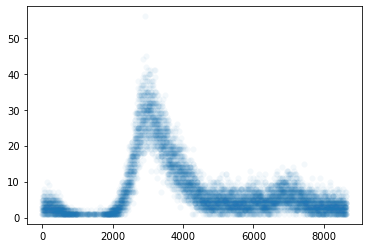

In [5]:
from collections import Counter
root_packets = routetable[router.environment.graph.root]
root_list = np.rint(list(root_packets.values()))%8640
c = Counter(root_list)
x = list(c.keys())
y = list(c.values())
plt.scatter(x,y, alpha=0.05, linewidth=0)

In [92]:
s_rt = pd.Series(routetable[router.environment.graph.root], name="tm")
df_post = packets.loc[packets["classification"] == "Healthy"].set_index("pid")
df_post["tm"] = pd.Series(routetable[router.environment.graph.root])
df_post.tail()
#pd.concat([df_post, s_rt], axis=1)

,classification,origin,t0,constituents,tm
pid,,,,,
P47125,Healthy,MH4624504053,2564,None,2923.139108
P47126,Healthy,MH4701905288,4934,None,5302.740364
P47127,Healthy,MH5512536693,2580,None,2722.264323
P47128,Healthy,MH4594705375,2432,None,2646.449352
P47129,Healthy,MH4607905204,2671,None,2914.050019


In [6]:
s_rt = pd.Series(routetable[router.environment.graph.root], name="tm")
df_post = packets.loc[packets["classification"] == "Healthy"].set_index("pid").join(s_rt)
df_post["age"] = (df_post["tm"]-df_post["t0"])*10

load_0 = router.environment.constituents.get("Cov-RNA").get("specific_load")
decay_rate = router.environment.constituents.get("Cov-RNA").get("decay_rate")
print(load_0, decay_rate)
df_post["l_red"] = load_0 * np.e ** (-decay_rate * df_post["age"] / 86400)
df_post["spread"] = 2 * (2 * 0.16 * df_post["age"]) ** 0.5
#df_post = df_post.head()
df_post

1000 0.114


,classification,origin,t0,constituents,tm,age,l_red,spread
pid,,,,,,,,
P0,Healthy,MH4576204803,2785,"[{'name': 'Fecal-Matter', 'specific_load': 200...",3153.730284,3687.302842,995.146625,68.700419
P1,Healthy,MH4740402381,7028,"[{'name': 'Fecal-Matter', 'specific_load': 200...",7722.876505,6948.765048,990.873393,94.310229
P2,Healthy,MH4662603926,2472,"[{'name': 'Fecal-Matter', 'specific_load': 200...",2792.172341,3201.723408,995.784414,64.017232
P3,Healthy,MH4467905208,2652,"[{'name': 'Fecal-Matter', 'specific_load': 200...",2812.501264,1605.012639,997.884516,45.325668
P4,Healthy,MH4530605770,3934,"[{'name': 'Fecal-Matter', 'specific_load': 200...",4186.020485,2520.204853,996.680252,56.796674
...,...,...,...,...,...,...,...,...
P47125,Healthy,MH4624504053,2564,None,2923.139108,3591.391083,995.272569,67.801037
P47126,Healthy,MH4701905288,4934,None,5302.740364,3687.403636,995.146492,68.701358
P47127,Healthy,MH5512536693,2580,None,2722.264323,1422.643227,998.124662,42.672981


In [ ]:
t = np.tile(np.arange(8640*2), (len(df_post),1))
tm = np.rint(df_post["tm"].values % 8640).astype(int)
spread = df_post["spread"].values
lred = df_post["l_red"].values
peak = 2 * lred / spread
cdt = peak/spread

In [ ]:
def _process_packet(x, tm, cdt, peak):
    left = np.maximum(0, -cdt*abs(x-tm) + peak)
    return left

In [ ]:
start = time.time()
results = _process_packet(t.T, tm, cdt, peak)
print(f"{time.time()-start}")

In [84]:
np.array([1.5,2.0]).astype(int)

array([1, 2])

In [ ]:
x1, x2 = np.split(results, 2)
#plt.plot((x1 + x2))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.scatter(x,y, alpha=0.05, linewidth=0)
ax2.plot(sum((x1 + x2).T))
#result.shape

In [72]:
def _process_packet1(packet):
    t, tm, dxleft, dxright, borderleft, borderright, peaks_fracts, dcleft, dcright = packet
    #print(t.shape)
    for fraction in zip(t, tm, dxleft, dxright, borderleft, borderright, peaks_fracts, dcleft, dcright):
        _process_fraction1(fraction)
    #print(f"Paketsumme: {np.sum(t)}")
    return None

def _process_fraction1(fraction):
    x, tm, dxleft, dxright, borderleft, borderright, peak, dcleft, dcright = fraction
    try:
        x[borderleft:tm] = -dcleft*abs(np.arange(borderleft-tm, 0)) + peak
    except:
        print(f"{borderleft} : {tm}\n",
              f"{tm-borderleft} : 0")
        x[borderleft:tm] = -dcleft*abs(np.arange(borderleft-tm, 0)) + peak
    try:
        x[tm:borderright] = -dcright*abs(np.arange(0, borderright-tm)) + peak
    except:
        print(f"{tm} : {borderright}\n",
              f"{borderright-tm} : 0")
        x[tm:borderright] = -dcright*abs(np.arange(0, borderright-tm)) + peak
    #print(f"Fraktionssumme: {sum(x)}")
    return x

In [73]:
fractions = np.array([0.5,0.5])
skewedness = np.array([1,7])

t = np.zeros([len(df_post), len(fractions), 8640*3])
tm = np.rint(df_post["tm"].values % 8640).astype(int) + 8640
tmfracts = np.repeat([tm], len(fractions), axis=0)

spread = df_post["spread"].values
dxleft = np.repeat([spread], len(fractions), axis=0).T
dxright = np.repeat([spread], len(fractions), axis=0).T * skewedness
borderleft = np.floor(np.repeat([tm], len(fractions), axis=0) - dxleft.T)
borderright = np.ceil(np.repeat([tm], len(fractions), axis=0) + dxright.T)

load_red = df_post["l_red"].values
load_fracts = np.repeat([load_red], len(fractions), axis=0).T * fractions
peaks_fracts = ((2*load_fracts).T / spread).T / ((skewedness + 1) * np.repeat([spread], len(fractions), axis=0).T)

dcleft = peaks_fracts / dxleft
dcright = peaks_fracts / dxright

start = time.time()
for i, packet in enumerate(zip(t, tmfracts.T, dxleft, dxright, borderleft.T, borderright.T,
                               peaks_fracts, dcleft, dcright)):
    #if i < 5:
        #print(f"{i}:")
        #_process_packet1(packet)
    _process_packet1(packet)
print(f"{time.time()-start}")

1.6519994735717773


In [30]:
tmfracts[:5].T
peaks_fracts[:5]

array([[0.1054237112954752, 0.0263559278238688],
       [0.055701972442898484, 0.013925493110724621],
       [0.12149028422484011, 0.030372571056210027],
       [0.24286328318293796, 0.06071582079573449],
       [0.15448276878120326, 0.038620692195300815]], dtype=object)

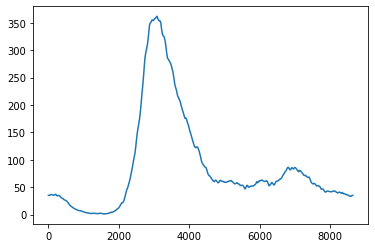

In [78]:
res = t[:]
res1, res2, res3 = np.split(res.T, 3)
res = (res1 + res2 + res3)
res = np.sum(res, axis=1)
res = np.sum(res, axis=1)
plt.plot(res)
#np.sum(np.sum(t[:5], axis=1), axis=1)
#plt.plot(res)
#res = np.sum(res, axis=1)

In [82]:
pd.DataFrame(np.sum(t[:5].T, axis=1))

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
25915,0.0,0.0,0.0,0.0,0.0
25916,0.0,0.0,0.0,0.0,0.0
25917,0.0,0.0,0.0,0.0,0.0
25918,0.0,0.0,0.0,0.0,0.0


In [ ]:
#peaks_fracts = 2 * load_fracts / ((skewedness + 1) * border)
(((2*load_fracts).T / spread).T / ((skewedness + 1) * np.repeat([spread], len(fractions), axis=0).T)).T

In [ ]:
ls = np.repeat([spread], 2, axis=0)
(ls.T * np.array([1,4])).T

In [ ]:
plt.plot(t.T)

In [ ]:
x1, x2, x3 = np.split(t.T, 3)
#plt.plot((x1 + x2))
plt.plot(sum((x1 + x2 + x3).T))

In [ ]:
left = np.array([1,2,3])
right = np.array([4,5,6])
np.concatenate([left, right])

In [ ]:
x = np.zeros(10)
x[3:6] = -cdt*abs(x[3:6]-5) + peak

In [ ]:
func(np.arange(10), 3, 3)

In [ ]:
import time
n = 60000
m = 8640
o = 2

In [ ]:
start = time.perf_counter()
np.array(n*[np.array(o * [np.arange(m)])])
print(time.perf_counter()-start)

In [ ]:
start = time.perf_counter()
np.repeat([np.repeat([np.arange(m)], o, axis=0)], n, axis=0)
print(time.perf_counter()-start)

In [ ]:
start = time.perf_counter()
ls = np.arange(m)
np.tile(ls, (n,2,1))
print(time.perf_counter()-start)

In [ ]:
x = np.array(2 * [np.arange(10)]).T
y = np.array([3,6])
func1(x[:5], y).T

In [ ]:
(np.array([[1,2,3],[4,5,6]]).T * np.array([2,3])).T